Starting by creating models for character level prediction and generation
1. Bigram
2. Bag of words
3. MLP
4. RNN
5. GRU
6. Transformer

We start with character level and then go into word and more. After which we will also delve into Images, Text.

In [108]:
words = open('names.txt', 'r').read().splitlines()
words[:10] # first 10 words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
len(words) # number of words

32033

In [4]:
min(len(w) for w in words) # shortest word
max(len(w) for w in words) # longest word

15

The piece of information that each word is giving is the following
1. word or name can start with specific char and following chars are possible predictions
2. word or name can end with specific character
3. lots of information is packed in the statistical nature of the word

In [11]:
# we will start with the Bigram model, 
# which basically means that we will look at the probability of a char given the previous char (only 2 chars at a time), 
# predicting the second char given the first char.

# we will finally use the frequency of the bigrams to predict the next char

b = {} # dictionary of bigrams, bigram as key, frequency as value
for word in words:
    chs = ['<S>'] + list(word) + ['</E>'] # add start and end symbols
    for ch1, ch2 in zip(chs, chs[1:]): # group the consective chars in a word
        bigram = (ch1, ch2) # create a bigram
        b[bigram] = b.get(bigram, 0) + 1 # increment the frequency of the bigram

In [13]:
b

sorted(b.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 bigrams

[(('n', '</E>'), 6763),
 (('a', '</E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '</E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [44]:
import torch

In [45]:
# let us store b in 2 dimensional array, 
# where the row starts with first element of the bigram and column starts with the second element of the bigram, values are the frequencies
# N = torch.zeros((27, 28), dtype=torch.int32) # 26 characters + start and end symbols
N = torch.zeros((27, 27), dtype=torch.int32) # 26 characters + . symbol

In [46]:
chars = sorted(list(set(''.join(words)))) # unique characters in the dataset
# lookup table for the characters
stoi = {ch: i+1 for i, ch in enumerate(chars)} # string to index dictionary, start index from 1, because 0 is reserved for padding
# stoi['<S>'] = 26 # start symbol
# stoi['<E>'] = 27 # end symbol
# lets instead use . as the end symbol
stoi['.'] = 0 # end symbol

itos = {i: ch for ch, i in stoi.items()} # index to string dictionary

In [47]:
# instead of dictionary, we will use N to store the bigrams
# we will have to index using integers instead of characters, so its imp to have a mapping from characters to integers

for word in words:
    # chs = ['<S>'] + list(word) + ['<E>'] # add start and end symbols
    chs = ['.'] + list(word) + ['.'] # add start and end symbols
    for ch1, ch2 in zip(chs, chs[1:]): # group the consective chars in a word
        i = stoi[ch1]
        j = stoi[ch2]
        N[i, j] += 1 # increment the frequency of the bigram

(-0.5, 26.5, 26.5, -0.5)

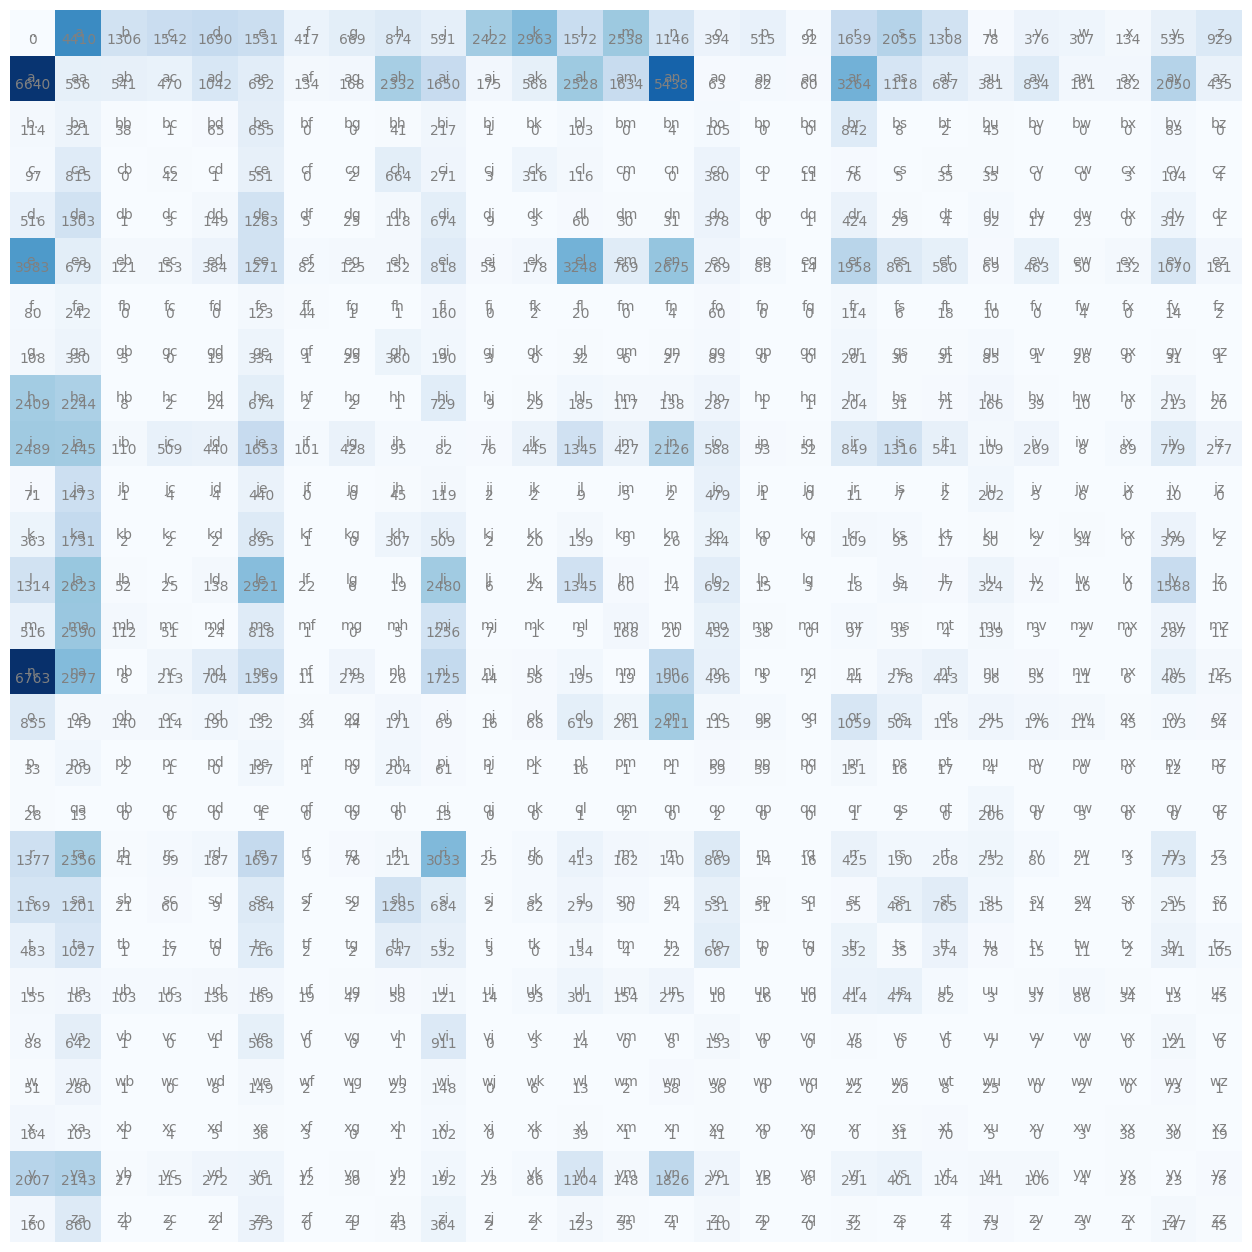

In [48]:
N # bigram frequencies looks ugly, lets use matplotlib to visualize it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.imshow(N) # plot the matrix

# visualization still looks bit ugly, lets modify using itos
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='center', color='gray') # plot the bigram
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray') # plot the frequency of each bigram (.item() converts tensor to int)))
plt.axis('off')

# important thing to note is that there is a zero colum and zero row, this is because S can never be followed by S and E can never be followed by E
# instead of using <> to denote S and E, we will use different technique
# top row is starting chars, first column is ending chars

So far we have done the following,
1. created torch tensor
2. created vocabulary - 26 words
3. created stoi and itos functions
4. created bigram from each word and stored it in the tensor
5. print the tensor

In [74]:
# lets use the stats from the tensor to predict the next char
# N[0] - convert to float
p = N[0].float()
p = p / p.sum() # normalize the probabilities
p
sum(p) # should be 1

tensor(1.)

In [75]:
g = torch.Generator().manual_seed(2147483647) # random seed, generator is used to be deter
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # draw only 1 sample from the distribution, this will be the top prediction
itos[ix] # convert the index to character


'c'

TESTING BELOW

In [64]:
# we need to sample from this distribution to get the next char
# lets use torch.multinomial to sample from this distribution (you give me probabilities, I will give you samples i.e. integers)
g = torch.Generator().manual_seed(2147483647) # random seed, generator is used to be deter
p = torch.rand(3, generator=g) # random numbers
p = p / p.sum() # normalize
p

tensor([0.6064, 0.3033, 0.0903])

In [68]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g) # sample 4 times with replacement

# important observation is the 60% of the times, we get 0 indice, 30% of the times we get 1 indice 
# and 9% of the times we get 2, which we can clearly see in the output

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [92]:
P.sum(0, keepdim=True).shape # 0 is the row
P.sum(1, keepdim=True).shape # 1 is the column

torch.Size([27, 1])

In [ ]:
# 27, 27 is the shape of the matrix, 27 is the number of rows and columns
# 27, 1
# we should be able to divide the above shapes? Go for broadcasting to check this
# here the rules of tensor broadcasting are applied
# 27, 1 is copied or stretched to 27, 27 a.k.a broadcasting

# 27, 27 is the shape of the matrix, 27 is the number of rows and columns
# 1, 27
# although broadcasting will be applied, but it will not work for our use case (this is when keepdim=False)

In [104]:
# tensor manipluation is an important skill to have
P = (N+1).float() # add 1 for model smoothing, like for name 'andrejq' - jq is 0, so loss will be infinite, so we add 1 to jq
P /= P.sum(1, keepdim=True) # normalize the probabilities, using dim=1, we are normalizing the rows

In [105]:
# main loop
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0 # start with start symbol
    while True:
        # convert this to a probability matrix to make it more efficient
        # p = N[ix].float()
        # p = p / p.sum() # normalize the probabilities

        p = P[ix]
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # draw only 1 sample from the distribution, this will be the top prediction
        out.append(itos[ix]) # convert the index to character
        if ix == 0: # if end symbol, break
            break
    print(''.join(out))

    # bigram is terrible

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [106]:
# lets now do some loss calculation
# we will be using likelihood loss, which is the product of the probabilities of the bigrams, this product will be very small, so we will use log likelihood loss
# log likelihood loss is the sum of the log of the probabilities of the bigrams 
# https://www.wolframalpha.com/input?i=log%28x%29+from+0+to+1 (log of probabilities are negative)

# log likelihood loss of -38 is not good (gets more -tive if the prob of bigrams are smaller, max +tive it can get is 0 for bigram prob of 1)
# , we need better representation of the loss, 
# we will use negative log likelihood loss, which is the negative of the log likelihood loss

log_likelihood = 0.0
n = 0
for word in words:
    # chs = ['<S>'] + list(word) + ['<E>'] # add start and end symbols
    chs = ['.'] + list(word) + ['.'] # add start and end symbols
    for ch1, ch2 in zip(chs, chs[1:]): # group the consective chars in a word
        i = stoi[ch1]
        j = stoi[ch2]
        prob = P[i, j]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}->{ch2} = {prob:.4f} => {logprob:.4f}')

print(f'log likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log likelihood = {nll:.4f}')
# average the likelihood
nll /= n
print(f'average negative log likelihood = {nll:.4f}')

log likelihood = -559951.5625
negative log likelihood = 559951.5625
average negative log likelihood = 2.4544


In [ ]:
# goal is to maximize the likelihood of the data w.r.t model parameters
# ultimately the probability tensor needs to be optimized, i.e. make the probabilites go to 1 for the bigrams that are present in the dataset. 
# In other words, make the average negative log likelihood loss go to 0

In [147]:
# TIME TO CREATE THE MODEL

# create the training set of bigrams
xs, ys = [], []
for word in words[:1]:
    chs = ['.'] + list(word) + ['.'] # add start and end symbols
    for ch1, ch2 in zip(chs, chs[1:]): # group the consective chars in a word
        i = stoi[ch1]
        j = stoi[ch2]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs) # tensor vs Tensor (int32 vs float32)
ys = torch.tensor(ys)

xs[0], ys[0]

(tensor(0), tensor(5))

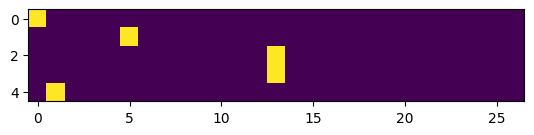

In [148]:
# FORWARD PASS

# feeding these inputs to the model requires us to convert them to one hot encoding
# we will use torch.nn.functional.one_hot to convert the inputs to one hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # input to nn should be float
xenc
xenc.shape # 14 is the length of the word, 27 is the number of characters
plt.imshow(xenc)

In [149]:
W = torch.randn(27, 1) # 27 is the number of characters, 1 is the number of hidden units (neurons)
xenc @ W # matrix multiplication

tensor([[-0.8015],
        [ 0.0794],
        [ 0.7937],
        [ 0.7937],
        [ 0.6082]])

In [150]:
# initialize the weights
# W = torch.randn(27, 1) # 27 is the number of characters, 1 is the number of hidden units (neurons)
g = torch.Generator().manual_seed(2147483647) # random seed, generator is used to be deter
W = torch.randn((27, 27), generator=g) # 27 is the number of characters, 27 is the number of hidden units (neurons)

xenc @ W # matrix multiplication

# with one neuron, we got 5, 1 shape
# with 27 neurons, we got 5, 27 shape

(xenc @ W)[3, 13] # it is 3rd input and 13th neuron, the activation strength is the output

tensor(0.0379)

In [151]:
# FORWARD PASS

# we need to convert the 27 neurons output to a probability distribution, we will use exp for it.
logits = xenc @ W # log counts
counts = logits.exp() # equal to N in the previous model
prob = counts / counts.sum(1, keepdim=True) # normalize the probabilities

# last 2 lines are softmax function - https://www.google.com/search?q=softmax&rlz=1C5CHFA_enGB1040GB1040&oq=softmax&gs_lcrp=EgZjaHJvbWUyDAgAEEUYORixAxiABDIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIGCAYQRRhBMgYIBxBFGD3SAQg0NDMzajBqNKgCALACAA&sourceid=chrome&ie=UTF-8#vhid=N5ww9pxz8Plq4M&vssid=l
# the above forward pass is also differentiable (we can calculate the gradients)
prob

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [152]:
# for input 0, output 0 is shown below, i.e. for . -> e, we need to now tune the weights to get closer to output

print(xenc[0]) # first input
print(prob[0]) # first output

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])


In [153]:
# lets look at some of the examples and losses
nlls = torch.zeros(5)  # 5 is the number of examples for example .emma

for i in range(5):
    # ith example bigram
    x = xs[i].item()
    y = ys[i].item()
    
    # forward pass
    print(f'bigram example {i+1}: {itos[x]}->{itos[y]} (indexes: {x}->{y})')
    print('input to the neural network:', x)
    print('output from the neural network:', prob[i])
    print('label (actual next character):', y)
    p = prob[i, y] # probability of the actual next character
    print('probability assigned by the net to the correct next character:', p.item())
    logp = torch.log(p) # log probability
    print('log likelihood:', logp.item())
    nll = -logp # negative log likelihood loss
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('===============================')
print('average negative log likelihood:', nlls.mean().item())

bigram example 1: .->e (indexes: 0->5)
input to the neural network: 0
output from the neural network: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the correct next character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
bigram example 2: e->m (indexes: 5->13)
input to the neural network: 5
output from the neural network: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the correct next character: 0.01805070228874683

In [154]:
# ----------------------!!! FINAL OPTIMIZATION !!!----------------------

In [196]:
xs

tensor([ 0,  5, 13, 13,  1])

In [197]:
ys

tensor([ 5, 13, 13,  1,  0])

In [198]:
# randomly initialize 27 neuron weights, each neuron will recieve 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [211]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to nn should be float
logits = xenc @ W # log counts
counts = logits.exp() # equal to N
probs = counts / counts.sum(1, keepdim=True) # normalize the probabilities

In [212]:
# loss calculation (actual - predicted)
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]
probs[torch.arange(5), ys] # predicted probabilities

loss = -probs[torch.arange(5), ys].log().mean() # average negative log likelihood loss

In [213]:
loss.item()

3.7291626930236816

In [208]:
# backward pass
W.grad = None # clear the gradients
loss.backward() # calculate the gradients

In [209]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0474,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1969,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0197,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [210]:
# update the weights
W.data += -0.1 * W.grad # learning rate of 0.1

In [ ]:
# BRING IT ALL TOGETHER

In [218]:
# create the training set of bigrams
xs, ys = [], []
for word in words:
    chs = ['.'] + list(word) + ['.'] # add start and end symbols
    for ch1, ch2 in zip(chs, chs[1:]): # group the consective chars in a word
        i = stoi[ch1]
        j = stoi[ch2]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs) # tensor vs Tensor (int32 vs float32)
ys = torch.tensor(ys)
num = xs.nelement() # number of elements in the tensor
print(f'number of elements in the tensor: {num}')

# initialize the neural network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of elements in the tensor: 228146


In [224]:
# we plan to add a component to a loss function called regularization, this when added to loss will try to get W's to zero
# probabilies want to be uniform and weights want to be zero, so we will add a component to the loss function
# 0.01 regularizer is equal to adding N+1 for smoothing
(W**2).mean() # square the weights

tensor(1.8610, grad_fn=<MeanBackward0>)

In [223]:
# neural network training loop
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to nn should be float
    logits = xenc @ W # log counts [remember that W cn be made 0, which will get us more uniform distribution, always try keeping the weights small i.e. close to 0, known as smoothing]
    counts = logits.exp() # equal to N
    probs = counts / counts.sum(1, keepdim=True) # normalize the probabilities
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # average negative log likelihood loss, add regularization to the loss, basically make the weights small
    print(f'loss at iteration {k+1}: {loss.item():.4f}')

    # backward pass
    W.grad = None # clear the gradients
    loss.backward() # calculate the gradients

    # update the weights
    W.data += -50 * W.grad # learning rate of 0.1

loss at iteration 1: 2.4878
loss at iteration 2: 2.4877
loss at iteration 3: 2.4876
loss at iteration 4: 2.4875
loss at iteration 5: 2.4874
loss at iteration 6: 2.4873
loss at iteration 7: 2.4872
loss at iteration 8: 2.4871
loss at iteration 9: 2.4870
loss at iteration 10: 2.4869
loss at iteration 11: 2.4868
loss at iteration 12: 2.4867
loss at iteration 13: 2.4867
loss at iteration 14: 2.4866
loss at iteration 15: 2.4865
loss at iteration 16: 2.4864
loss at iteration 17: 2.4863
loss at iteration 18: 2.4863
loss at iteration 19: 2.4862
loss at iteration 20: 2.4861
loss at iteration 21: 2.4860
loss at iteration 22: 2.4860
loss at iteration 23: 2.4859
loss at iteration 24: 2.4858
loss at iteration 25: 2.4858
loss at iteration 26: 2.4857
loss at iteration 27: 2.4856
loss at iteration 28: 2.4856
loss at iteration 29: 2.4855
loss at iteration 30: 2.4855
loss at iteration 31: 2.4854
loss at iteration 32: 2.4853
loss at iteration 33: 2.4853
loss at iteration 34: 2.4852
loss at iteration 35: 2

In [226]:
# finally, lets sample from the model

g = torch.Generator().manual_seed(2147483647) # random seed, generator is used to be deter

for i in range(5):
    out = []
    ix = 0 # start with start symbol

    while True:
        # p = probs[ix] older way of doing it
        # lets use neural network to predict the next character
        xenc = F.one_hot(torch.tensor(ix), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(0, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
